/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 203s 321ms/step - accuracy: 0.5080 - loss: 0.6931 - val_accuracy: 0.5107 - val_loss: 0.6915
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 199s 322ms/step - accuracy: 0.5443 - loss: 0.6748 - val_accuracy: 0.5383 - val_loss: 0.6768
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 207s 330ms/step - accuracy: 0.7103 - loss: 0.5277 - val_accuracy: 0.8766 - val_loss: 0.3055
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 260s 325ms/step - accuracy: 0.9167 - loss: 0.2305 - val_accuracy: 0.8841 - val_loss: 0.2959
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 263s 327ms/step - accuracy: 0.9517 - loss: 0.1514 - val_accuracy: 0.8783 - val_loss: 0.3319
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 259s 323ms/step - accuracy: 0.9731 - loss: 0.0936 - val_accuracy: 0.8531 - val_loss: 0.4117
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 198s 319ms/step - accuracy: 0.9818 - loss: 0.0636 - val_accuracy: 0.8746 - val_loss: 0.4650
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 200s 316ms/step - accuracy: 0.9875 -

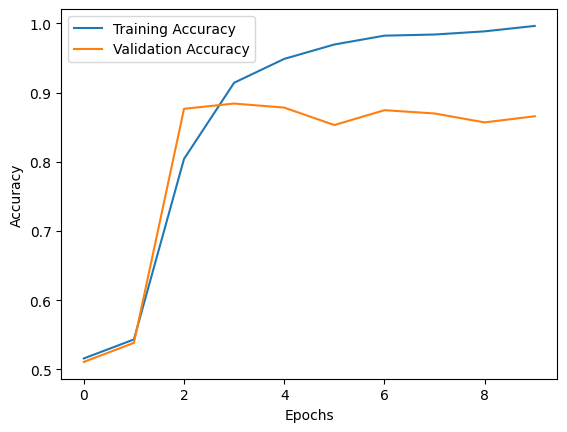

Ngrok tunnel "NgrokTunnel: "https://0aa9-34-23-73-173.ngrok-free.app" -> "http://localhost:5000"" -> "http://127.0.0.1:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


In [ ]:
# Cài đặt Flask và pyngrok
!pip install Flask pyngrok

import pandas as pd
import numpy as np
import nltk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from flask import Flask, request, render_template
from pyngrok import ngrok
import os

# Tải NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)

# Tạo tệp index.html
html_content = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Sentiment Analysis</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f4f4f4;
            padding: 20px;
            text-align: center;
        }
        .container {
            background-color: white;
            border-radius: 8px;
            padding: 20px;
            box-shadow: 0 2px 10px rgba(0, 0, 0, 0.1);
            max-width: 500px;
            margin: auto;
        }
        h1 {
            color: #333;
        }
        textarea {
            width: 100%;
            padding: 10px;
            margin-top: 10px;
            margin-bottom: 10px;
            border: 1px solid #ccc;
            border-radius: 4px;
            resize: none;
        }
        input[type="submit"] {
            background-color: #5cb85c;
            color: white;
            padding: 10px 15px;
            border: none;
            border-radius: 4px;
            cursor: pointer;
        }
        input[type="submit"]:hover {
            background-color: #4cae4c;
        }
        h2 {
            margin-top: 20px;
            color: #555;
        }
        .score {
            font-weight: bold;
            color: #007bff;
        }
    </style>
</head>
<body>
    <div class="container">
        <h1>Nhận diện cảm xúc đánh giá phim 🎬</h1>
        <form method="POST">
            <textarea name="user_input" rows="4" cols="50" placeholder="Nhập đánh giá phim..."></textarea><br>
            <input type="submit" value="Dự đoán cảm xúc">
        </form>
        <h2>Dự đoán: {{ prediction }}</h2>
        {% if score %}
            <p class="score">Tỉ lệ dự đoán: {{ score }}</p>
        {% endif %}
    </div>
</body>
</html>
"""

# Tạo thư mục templates nếu chưa tồn tại
if not os.path.exists('templates'):
    os.makedirs('templates')

# Tạo tệp index.html trong thư mục templates
with open('templates/index.html', 'w') as f:
    f.write(html_content)

# Khởi tạo Flask
app = Flask(__name__)

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NCKH_code1/reviews.csv', encoding="ISO-8859-1")

# Kiểm tra cột dữ liệu
if 'Text' not in df.columns or 'Sentiment' not in df.columns:
    raise ValueError("Dataset is missing required columns: 'Text' and 'Sentiment'")

# Tiền xử lý dữ liệu
df.drop_duplicates(inplace=True)
df.dropna(subset=['Text', 'Sentiment'], inplace=True)

def preprocess_text(text):
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = nltk.word_tokenize(text.lower())
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]
    return ' '.join(filtered_tokens)

df['Text'] = df['Text'].apply(preprocess_text)

# Mã hóa nhãn
le = LabelEncoder()
y = le.fit_transform(df['Sentiment'])

# Chuẩn bị dữ liệu
X = df['Text']
MAX_WORDS = 10000
MAX_LENGTH = 200
EMBEDDING_DIM = 128

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Chia dữ liệu
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42, shuffle=True)

# Xây dựng mô hình
model = Sequential()
model.add(Embedding(MAX_WORDS, EMBEDDING_DIM, input_length=MAX_LENGTH))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

# Evaluate model
y_pred = (model.predict(X_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

# Visualize training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Hàm dự đoán cảm xúc
def predict_sentiment(text):
    processed_text = preprocess_text(text)
    sequence = tokenizer.texts_to_sequences([processed_text])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LENGTH)
    score = model.predict(padded_sequence)[0][0]  # Lấy giá trị tỉ lệ
    print(f"Score: {score}")  # In ra giá trị dự đoán
    prediction = "Positive" if score > 0.5 else "Negative"
    return prediction, score  # Trả về cả dự đoán và tỉ lệ

# Định nghĩa route cho trang chính
@app.route('/', methods=['GET', 'POST'])
def index():
    prediction = ""
    score = None
    if request.method == 'POST':
        user_input = request.form['user_input']
        prediction, score = predict_sentiment(user_input)
    return render_template('index.html', prediction=prediction, score=score)

# Thay thế 'YOUR_AUTHTOKEN' bằng mã thông báo xác thực của bạn
ngrok.set_auth_token("2ujCdDkaOVBkBmrqIRJACyVCwRD_2nF1MMtFrfkdkjTpKxkJT")

# Mở một đường hầm ngrok
public_url = ngrok.connect(5000)
print("Ngrok tunnel \"{}\" -> \"http://127.0.0.1:5000\"".format(public_url))

# Chạy ứng dụng
if __name__ == '__main__':
    app.run()

In [ ]:
!pip install Flask pyngrok

In [ ]:
from pyngrok import ngrok

# Thay thế 'YOUR_AUTHTOKEN' bằng mã thông báo xác thực của bạn
ngrok.set_auth_token("2ujCdDkaOVBkBmrqIRJACyVCwRD_2nF1MMtFrfkdkjTpKxkJT")